In [0]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler

import math
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
def read_fire_data(filename, year_col, doy_col):
  df = pd.read_csv(filename)
  df['date'] = df[year_col].apply(lambda x: datetime.datetime(x, 1, 1)) + df[doy_col].apply(lambda x: datetime.timedelta(x - 1))
  df.set_index('date', inplace = True)
  del df[year_col], df[doy_col], df['Unnamed: 0']
  return df

In [0]:
df = read_fire_data('fire_raw.csv', 'FIRE_YEAR', 'DISCOVERY_DOY')
df.head()

,FIRE_SIZE,STATE,FIPS_CODE
date,,,
2005-02-02,0.10,CA,63.0
2004-05-12,0.25,CA,61.0
2004-05-31,0.10,CA,17.0
2004-06-28,0.10,CA,3.0
2004-06-28,0.10,CA,3.0


In [0]:
#This is the most recent monthly data on Wild Fires
import datetime
lis = [[3131, 439], [123490, 2455], [649511, 6324], [687131, 6267], [134720, 4942], [526926, 5230], [1353260, 8195], [1116726, 6507], [285893, 4762], [126963, 6555], [275616, 8560], [163153, 5339], [54961, 2459], [167766, 5353], [957427, 6717], [817985, 5953], [234986, 4182], [600373, 5336], [2657380, 9000], [1648583, 7493], [1325423, 3033], [366641, 3408], [354376, 3252], [595161, 9945], [71189, 3257], [67289, 3200], [392010, 6297], [446198, 4938], [707411, 6197], [812501, 5112], [2313597, 8717], [2129088, 7861], [841953, 3720], [466374, 1791], [236457, 1421], [98542, 3400], [13095, 1139], [27604, 1018], [130508, 4934], [40716, 3534], [120868, 5338], [1331968, 5657], [1570697, 5571], [1001587, 8765], [195898, 6627], [134013, 2314]]

idx = []
for n in range(4):
  for i in range(12):
    idx.append(datetime.date(2016 + n, 1 + i, 1))
len(idx)
idx = idx[:-2]
recent = pd.DataFrame(lis, columns = ['acres', 'amount'], index = idx)

In [0]:
# scale fit on total dataset
# for n in range(recent.shape[0]):
#   transform
#   create dataset
#   next_month = model.predict()
#   append(next_month)
#   delete the last date

In [0]:
# def selection(df, states = None, cause = None):
#   latest_date = df.index.max()
#   earliest_date = df.index.min()
#   temp_df = df
#   if states not None:
#     temp_df = temp_df[temp_df['STATE'].apply(lambda x: x in states)]
#   # if cause not None: Need to add cause in original data set
#   #   temp_df = ....
  

In [0]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

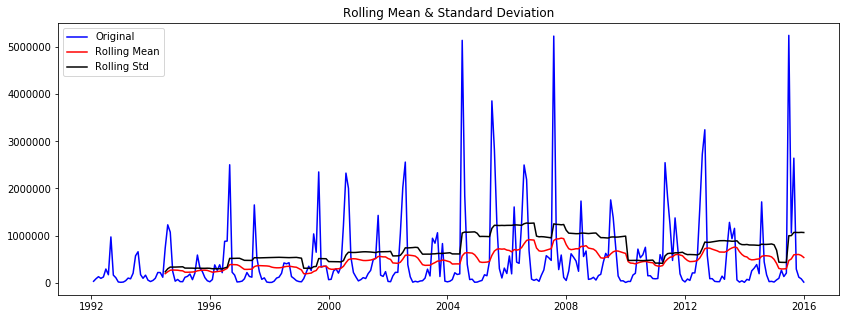

<Results of Dickey-Fuller Test>
Test Statistic                  -3.218357
p-value                          0.018946
#Lags Used                      11.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


In [0]:
#Grouby by a time
test_stationarity(df.resample('M').sum().FIRE_SIZE)

In [0]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [0]:
df.sort_values(by='date').head()

,FIRE_SIZE,STATE,FIPS_CODE
date,,,
1992-01-01,1.0,NC,NaN
1992-01-01,20.0,MS,111.0
1992-01-01,2.0,MS,121.0
1992-01-01,1.0,MS,153.0
1992-01-01,5.0,SC,41.0


In [0]:
mon_sum = df.resample('M', label= 'left').count().FIRE_SIZE
mon_sum.index = mon_sum.index + datetime.timedelta(1)
# append(recent['acres'])
tot_sum = mon_sum.append(recent['amount'])


In [0]:

dataset = tot_sum.values
# dataset  = df.resample('M', label= 'left').sum().FIRE_SIZE.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1)) #May want to play with different scalers
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 12 #Play with different look backs
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=1000, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False) #Need to add the save best model

model.summary()

Train on 254 samples, validate on 54 samples
Epoch 1/1000
254/254 [==============================] - 2s 8ms/sample - loss: 0.1489 - val_loss: 0.0801
Epoch 2/1000
254/254 [==============================] - 0s 139us/sample - loss: 0.1245 - val_loss: 0.0655
Epoch 3/1000
254/254 [==============================] - 0s 101us/sample - loss: 0.1025 - val_loss: 0.0525
Epoch 4/1000
254/254 [==============================] - 0s 95us/sample - loss: 0.0827 - val_loss: 0.0411
Epoch 5/1000
254/254 [==============================] - 0s 96us/sample - loss: 0.0652 - val_loss: 0.0317
Epoch 6/1000
254/254 [==============================] - 0s 95us/sample - loss: 0.0505 - val_loss: 0.0246
Epoch 7/1000
254/254 [==============================] - 0s 104us/sample - loss: 0.0393 - val_loss: 0.0201
Epoch 8/1000
254/254 [==============================] - 0s 101us/sample - loss: 0.0322 - val_loss: 0.0182
Epoch 9/1000
254/254 [==============================] - 0s 98us/sample - loss: 0.0290 - val_loss: 0.0183
Epoch 1

In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 308183.9347825966
Train Root Mean Squared Error: 571770.1289690062
Test Mean Absolute Error: 431804.6889168853
Test Root Mean Squared Error: 900087.0061673688


In [0]:
dftest = adfuller(Y_test, autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                      index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

ValueError: ignored

In [0]:
months = 60
start = X_test[-1].reshape((1,1,look_back))
out = []
for i in range(months):
  next_mon = model.predict(start[0][0][-look_back:].reshape(1,1,look_back))
  start = np.append(start, next_mon).reshape(1, 1, look_back+i +1)
  out.append(next_mon)

In [0]:
arr = np.asarray(out).reshape((months, 1))
arr_tran = scaler.inverse_transform(arr)

In [0]:
idx = []
for n in range(6):
  for i in range(12):
    idx.append(datetime.date(2019 + n, 1 + i, 1))
len(idx)
idx = idx[10:-2]

In [0]:
len(idx)

48

In [0]:
df_cou_preds = pd.DataFrame(arr_tran, index = idx, columns=['col'])

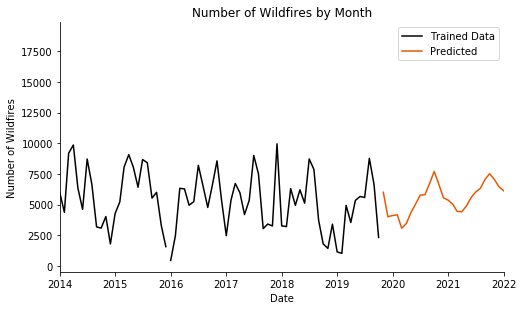

In [0]:
# plt.plot(df.resample('M').sum().FIRE_SIZE)
plt.figure(figsize=(7,4))
plt.plot(df.resample('M', label= 'left').count().FIRE_SIZE, label = 'Trained Data', c = 'black')
plt.plot(df_cou_preds, label = 'Predicted', c = '#eb5600')
plt.plot(recent['amount'], c = 'black')
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('Number of Wildfires')
plt.xlabel('Date')
plt.title('Number of Wildfires by Month')
plt.xlim((datetime.date(2014, 1, 1), datetime.date(2022, 1, 1)))
plt.ylim()
plt.legend()

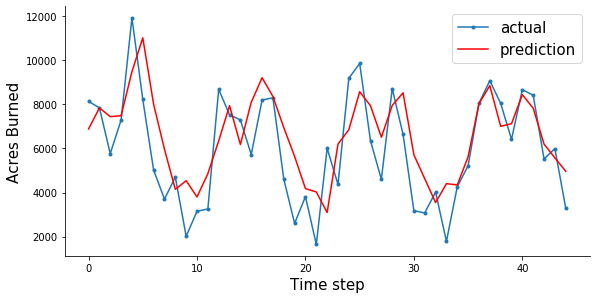

In [0]:
aa=[x for x in range(45)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:45], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:45], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Acres Burned', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()